## Análise Geral

**Disciplina: Redes Sociais**

**Grupo: Antonio Fuziy, Eiki Yamashiro e Marcelo Cesário**


#### Importação das bibliotecas

In [1]:
import pandas as pd
import os
from graph_tool import Graph, stats, spectral,centrality
import statsmodels.formula.api as smf

from netpixi.data.gt import *
import netpixi
import cpnet
import seaborn as sns
from math import sqrt
from matplotlib import rcParams
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm
import difflib
import seaborn as sns
from matplotlib import rcParams

#### Ligas disponíveis

O dataset de transferências possui os dados das seguintes ligas:

#### Problemas:

- Sub21 e Sub18
DATA_DIR = './data/transfers_master/data'- Incoerência entre as colunas club_name e club_involved_name

In [2]:
DATA_DIR = './data/transfers_master/data'
os.listdir(DATA_DIR + '/' + '2014')

['spanish_primera_division.csv',
 'dutch_eredivisie.csv',
 'portugese_liga_nos.csv',
 'french_ligue_1.csv',
 'italian_serie_a.csv',
 'russian_premier_liga.csv',
 'english_premier_league.csv',
 'english_championship.csv',
 'german_bundesliga_1.csv']

#### Loading Data

Função para carregar o dataset. Recebe o diretório que o data está salvo e o ano.

In [3]:
def loading_data(DATA_DIR, year):
    
    # Leitura do primeiro dataset para carregar as columns
    primeiro = 0
    # Loop desconsidera o primeiro elemento (carregado no código acima)
    for league in os.listdir(DATA_DIR + '/' + year)[0:]:
            string = (DATA_DIR + '/' + year + '/' + league)
            data_temp = pd.read_csv(string)
            if primeiro == 0:
                data = data_temp
                primeiro = 1
            else:
                # Concatenação dos dados
                data = pd.concat([data, data_temp])
     
    return(data)

def concat_year(start, end, DATA_DIR, data):
    
    for year in range(start, end+1):
        data = pd.concat([data, loading_data(DATA_DIR, str(year))])
        
    return data

In [4]:
DATA_DIR = './data/transfers_master/data'
YEAR = '1992'

data = loading_data(DATA_DIR, YEAR)
# data

In [5]:
data = concat_year(1993, 2015, DATA_DIR, data)

In [6]:
data_in = data.loc[data["transfer_movement"] == "in"]
data_out = data.loc[data["transfer_movement"] == "out"]
data_in = data_in.reset_index()
data_out = data_out.reset_index()

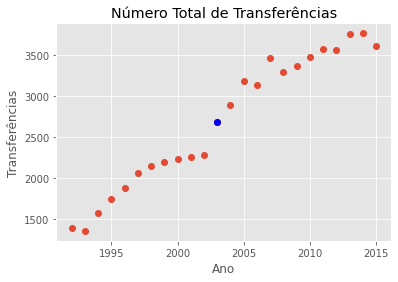

In [7]:
import matplotlib.pyplot as plt

pl = data_in["year"].value_counts()
pre_gal = pl.sort_index()
pos_gal = pl.sort_index()
pre_gal = pre_gal[:11]
pos_gal = pos_gal[11:]

plt.style.use('ggplot')
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.plot(pl.sort_index(), 'o', label = "Transferências")
plt.plot(2003 ,pl[2003], 'bo', label = "Era");

## Pré-Galácticos e Pós-Galacticos

O gráfico acima mostra a evolução no número de transferências de jogadores ao longo dos anos, dessa forma pode-se perceber que 2003 foi o ano em que houve a maior evolução no número de movimentações no mercado do futebol europeu da história. Portanto, deixou-se essa data como destaque em azul no gráfico, marcando o fim da era dos galácticos e o começo da era pós galácticos.

Assim, como o segundo gráfico mostra os anos em rosa que indicam a era pré-galácticos e os em azul a era pós-galácticos. 

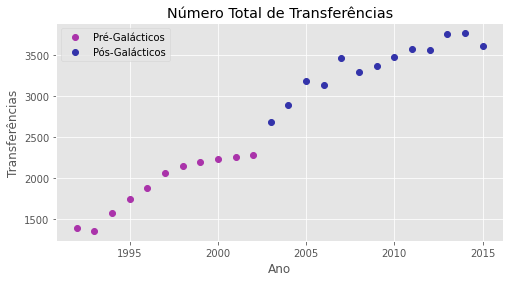

In [8]:
plt.figure(figsize = (8,4))
plt.plot(pre_gal, 'o', label = "Pré-Galácticos", color = "#AA33AA")
plt.plot(pos_gal, 'o', label = "Pós-Galácticos", color = "#3333AA")
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.legend(loc="upper left")
plt.show()

In [9]:
in_names = list(data_in["club_name"].value_counts().index)
out_names = list(data_in["club_involved_name"].value_counts().index)
name_dic = {}
problems = ["Olympique Marseille", "Olympique Lyon", "Eintracht Braunschweig", "Eintracht Frankfurt"]
for in_str in in_names:
    for out_str in out_names:

        if out_str[:10] in in_str and out_str != in_str:
            if (out_str not in problems) or (in_str not in problems):
#                 print(in_str ,", ", out_str)
                name_dic[out_str] = in_str

In [10]:
for k,v in name_dic.items():
    data_in["club_involved_name"].replace({k: v}, inplace=True)
    
# data_in

In [11]:
data_pre_gal = data_in[data_in["year"] <= 2003]
data_pos_gal =  data_in[data_in["year"] > 2003]

In [12]:
rede_normal = Graph(directed=True) # dirigido
rede_normal.vp['name'] = rede_normal.new_vp('object')
rede_normal.vp['league'] = rede_normal.new_vp('object')
rede_normal.ep["transfer"] = rede_normal.new_ep('object')

In [13]:
times = []
for index, rows in data_in.iterrows():
    time1 = rows[1]
    time2 = rows[5]
    if time1 not in times:
        times.append(time1)
        rede_normal.add_vertex()
        v_time = rede_normal.vertex(times.index(time1))
        rede_normal.vp['name'][v_time] = time1
        rede_normal.vp['league'][v_time] = rows[10]
        
    if time2 not in times:
        times.append(time2)
        rede_normal.add_vertex()
        v_time = rede_normal.vertex(times.index(time2))
        rede_normal.vp['name'][v_time] = time2
        rede_normal.vp['league'][v_time] = rows[10]
    
    index1 = times.index(time1)
    index2 = times.index(time2)
    
    if rede_normal.edge(index1, index2) == None:
        rede_normal.add_edge(index1, index2)
        e = rede_normal.edge(index1, index2)
        rede_normal.ep["transfer"][e] = 1
    else:
        e = rede_normal.edge(index1, index2)
        rede_normal.ep["transfer"][e] = rede_normal.ep["transfer"][e] + 1

In [14]:
data_in["league_name"].value_counts()

Championship        12342
Premier League       9652
Serie A              7532
Liga Nos             7382
Ligue 1              6365
Primera Division     5988
Eredivisie           5608
1 Bundesliga         5163
Premier Liga         4923
Name: league_name, dtype: int64

In [15]:
rede_normal.vp['color'] = rede_normal.new_vp('object')

for v in rede_normal.vertices():
    if rede_normal.vp['league'][v] == "Premier League":
        rede_normal.vp['color'][v] = 0x61dafb
        #61dafb
    if rede_normal.vp['league'][v] == "Eredivisie":
        rede_normal.vp['color'][v] = 0x915bff
        #915bff
    if rede_normal.vp['league'][v] == "Championship":
        rede_normal.vp['color'][v] = 0xbababa
        #bababa
    if rede_normal.vp['league'][v] == "Serie A":
        rede_normal.vp['color'][v] = 0x00ff00
        #00ff00
    if rede_normal.vp['league'][v] == "Liga Nos":
        rede_normal.vp['color'][v] = 0xffa7b6
        #ffa7b6
    if rede_normal.vp['league'][v] == "Ligue 1":
        rede_normal.vp['color'][v] = 0x0000ff
        #0000ff
    if rede_normal.vp['league'][v] == "1 Bundesliga":
        rede_normal.vp['color'][v] = 0xff0000
        #ff0000
    if rede_normal.vp['league'][v] == "Premier Liga":
        rede_normal.vp['color'][v] = 0x8f2f00
        #8f2f00
    if rede_normal.vp['league'][v] == "Primera Division":
        rede_normal.vp['color'][v] = 0xffda28
        #ffda28
        
stats.remove_self_loops(rede_normal)
m = draw_gt.sfdp_layout(rede_normal)
move_gt(rede_normal, m)
save_gt(rede_normal, 'rede_normal.net.gz')
# r = netpixi.render('exemplo4.net.gz')

In [16]:
def centro_periferia(g, t):
    matrix = spectral.adjacency(g)
    if t == "core":
        algorithm = cpnet.LowRankCore()
    elif t == "coreness":
        algorithm = cpnet.MINRES()

    algorithm.detect(matrix)
    c = algorithm.get_coreness()

    g.vp[t] = g.new_vp('object')
    for i, coreness in c.items():
        v = g.vertex(i)
        g.vp[t][v] = float(coreness)

In [17]:
centro_periferia(rede_normal, "core")

In [18]:
df = pd.DataFrame({k: list(v) for k, v in rede_normal.vp.items()})
df.head()

,name,league,color,_x,_y,core
0,Real Sociedad,Primera Division,16767528,3.757063,1.537819,0.0
1,R. Sociedad U19,Primera Division,16767528,3.723533,1.536532,0.0
2,Cádiz CF,Primera Division,16767528,3.761083,1.545748,0.0
3,Hajduk Split,Primera Division,16767528,3.752443,1.540548,0.0
4,CD Málaga,Primera Division,16767528,3.777316,1.558547,0.0


In [19]:
df["league"].value_counts()

Liga Nos            612
Premier Liga        541
Serie A             472
1 Bundesliga        415
Eredivisie          410
Ligue 1             375
Championship        363
Premier League      331
Primera Division    300
Name: league, dtype: int64

In [20]:
def plot_cp(df):
    plt.figure(figsize=(16,8))
    plt.plot(df[df["league"] == "Eredivisie"]["_x"], df[df["league"] == "Eredivisie"]["_y"],
             'o', markersize=12, label = "Eredivisie", alpha=.5, color="#915bff")
    plt.plot(df[df["league"] == "Liga Nos"]["_x"], df[df["league"] == "Liga Nos"]["_y"],
             'o', markersize=12, label = "Liga Nos", alpha=.5, color="#ffa7b6")
    plt.plot(df[df["league"] == "Premier Liga"]["_x"], df[df["league"] == "Premier Liga"]["_y"],
             'o', markersize=12, label = "Premier Liga", alpha=.5, color="#8f2f00")
    plt.plot(df[df["league"] == "Championship"]["_x"], df[df["league"] == "Championship"]["_y"],
             'o', markersize=12, label = "Championship", alpha=.5, color="#bababa")
    plt.plot(df[df["league"] == "Serie A"]["_x"], df[df["league"] == "Serie A"]["_y"],
             'o', markersize=12, label = "Serie A", alpha=.5, color="#00ff00")
    plt.plot(df[df["league"] == "Ligue 1"]["_x"], df[df["league"] == "Ligue 1"]["_y"],
             'o', markersize=12, label = "Ligue 1", alpha=.5, color="#0000ff")
    plt.plot(df[df["league"] == "Premier League"]["_x"], df[df["league"] == "Premier League"]["_y"],
             'o', markersize=12, label = "Premier League", alpha=.5, color="#61dafb")
    plt.plot(df[df["league"] == "1 Bundesliga"]["_x"], df[df["league"] == "1 Bundesliga"]["_y"],
             'o', markersize=12, label = "1 Bundesliga", alpha=.5, color="#ff0000")
    plt.plot(df[df["league"] == "Primera Division"]["_x"], df[df["league"] == "Primera Division"]["_y"],
             'o', markersize=12, label = "Primera Division", alpha=.5, color="#ffda28")
    plt.title("Classificação core & liga")
    plt.xlabel("posição em X")
    plt.ylabel("posição em Y")
    plt.legend(loc = "upper right")
    plt.show()

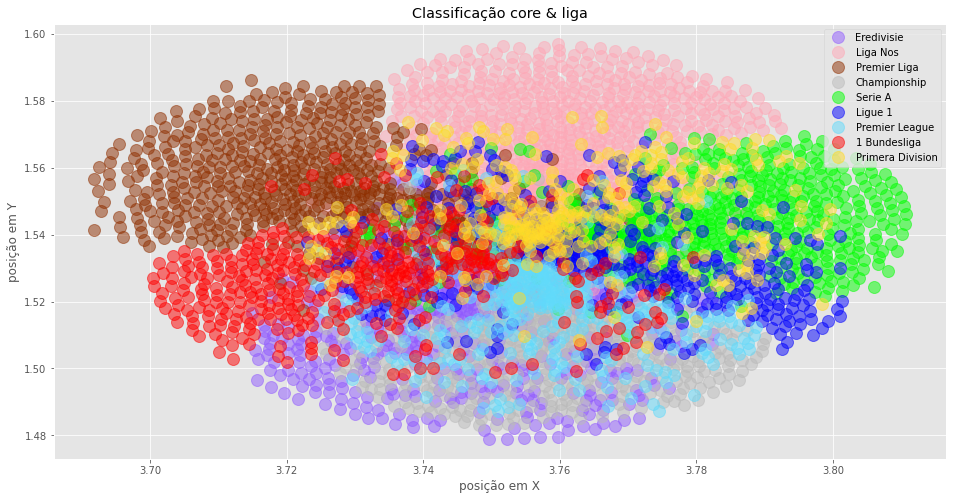

In [21]:
plot_cp(df)

In [22]:
df

,name,league,color,_x,_y,core
0,Real Sociedad,Primera Division,16767528,3.757063,1.537819,0.0
1,R. Sociedad U19,Primera Division,16767528,3.723533,1.536532,0.0
2,Cádiz CF,Primera Division,16767528,3.761083,1.545748,0.0
3,Hajduk Split,Primera Division,16767528,3.752443,1.540548,0.0
4,CD Málaga,Primera Division,16767528,3.777316,1.558547,0.0
...,...,...,...,...,...,...
3814,Pune City,Championship,12237498,3.780336,1.500780,0.0
3815,Kyung Hee Univ.,1 Bundesliga,16711680,3.714303,1.537486,0.0
3816,Odds BK,1 Bundesliga,16711680,3.714665,1.513518,0.0
3817,FC Vysocina,1 Bundesliga,16711680,3.766788,1.511198,0.0


## Conclusão sobre o grafo das tranferências entre clubes europeus

Observando o grafo plotado, é possível observar panelinhas entre as ligas do futebol europeu, fica bem claro a concentração entre os times de mesma liga quando se olha para as cores e os devidos posicionamentos dos vértices ao longo da rede, assim fica mais evidente a possível existência de times que interligam tranferências entre as ligas, os quais corroboram para a hipótese do grupo.

**Hipótese: Times com boa relação com times de diferentes ligas (relacionamento interliga) atingem melhor desempenho na champions league**


In [23]:
def loading_champions_data(DATA_DIR, year, end):
    list_df = []
    str_year = f"{year}-{str(year+1)[-2:]}"
    dir = "./data/champions_league/"+ str_year + "/champs.csv"
    data = pd.read_csv(dir)
    list_df.append(data)
    start = year + 1
    
    for year in range(start, end+1):
        str_year = f"{year}-{str(year+1)[-2:]}"
        dir = "./data/champions_league/"+ str_year + "/champs.csv"
        
        #data = pd.concat([data, pd.read_csv(dir)])
        data = pd.read_csv(dir)
        list_df.append(data)
    return(list_df)

In [24]:
DATA_DIR = './data/champions_league'
YEAR = 1993

list_df = loading_champions_data(DATA_DIR, YEAR, 2015)
list_df[1]


,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),AEK Athens › GRE (1),2-0,0-0,Rangers FC › SCO (1),NaN,NaN,NaN,NaN
1,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Avenir Beggen › LUX (1),1-5,0-0,Galatasaray İstanbul AŞ › TUR (1),NaN,NaN,NaN,NaN
2,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Silkeborg IF › DEN (1),0-0,0-0,Dinamo Kiev › UKR (1),NaN,NaN,NaN,NaN
3,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Paris Saint-Germain › FRA (1),3-0,0-0,Dunakanyar-Vac › HUN (1),NaN,NaN,NaN,NaN
4,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Legia Warsaw › POL (1),0-1,0-0,Hajduk Split › CRO (1),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
72,Knockout,Semifinals | Leg 1,NaN,(Wed) 5 Apr 1995 (W14),Paris Saint-Germain › FRA (11),0-1,0-0,AC Milan › ITA (9),NaN,NaN,NaN,NaN
73,Knockout,Semifinals | Leg 1,NaN,(Wed) 5 Apr 1995 (W14),Bayern München › GER (9),0-0,0-0,AFC Ajax › NED (9),NaN,NaN,NaN,NaN
74,Knockout,Semifinals | Leg 2,NaN,(Wed) 19 Apr 1995 (W16),AFC Ajax › NED (10),5-2,3-1,Bayern München › GER (10),5-2 (agg.),NaN,NaN,NaN
75,Knockout,Semifinals | Leg 2,NaN,(Wed) 19 Apr 1995 (W16),AC Milan › ITA (10),2-0,1-0,Paris Saint-Germain › FRA (12),3-0 (agg.),NaN,NaN,NaN


In [25]:
def calcula_pontos(stage,round_,time1,time2,time1_placar,time2_placar,comentarios,dict_teams):
    pontos_ = 0
    if stage == 'Qualifying':
        pontos_=1
    elif stage == 'Group':
        pontos_=3
    else:
        pontos_ = 5
    if round_ == 'Final':
        pontos_ = 10
    
    
    if time1 not in dict_teams:
        dict_teams[time1] = 0
        
    if time2 not in dict_teams:
        dict_teams[time2] = 0
        
    if comentarios !=0:
        if comentarios == 1:
            time_vencedor = time1
        if comentarios == 2:
            time_vencedor = time2
    
    if time1_placar > time2_placar:
        time_vencedor = time1
    else:
        time_vencedor = time2
    dict_teams[time_vencedor] +=pontos_


In [26]:
dict_teams = {}
for i in range(len(list_df)):
    list_df[i]['Team 1'] = list_df[i]['Team 1'].str.split(' ›').str[0]
    list_df[i]['Team 2'] = list_df[i]['Team 2'].str.split(' ›').str[0]
    #list_df[i] = list_df[i].dropna(subset=['∑FT'])
    # limpando '∑FT'
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("(","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(")","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("a ","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("agg.","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(" ","")
    list_df[i]['time1_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[0]
    list_df[i]['time2_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[1]
    # limpando P
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace('(','')
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace(")","", regex=True)
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace("pen.","", regex=True)
    list_df[i]['time1_penalti'] = list_df[i]['P'].str.split('-').str[0]
    list_df[i]['time2_penalti'] = list_df[i]['P'].str.split('-').str[1]
    
    # limpando Comments (Away Goals)
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('(','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace(')','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('Away Goals ','')
    
    list_df[i]['time1_placar'] = list_df[i]['FT'].str.split('-').str[0]
    list_df[i]['time1_placar'] = list_df[i]['time1_placar'].str.replace(' ','')
    list_df[i]['time2_placar'] = list_df[i]['FT'].str.split('-').str[1]
    list_df[i] = list_df[i].drop(list_df[i][((list_df[i]['Stage'] == 'Knockout') & (list_df[i]['∑FT'].isnull()) & (list_df[i]['Round'] != 'Final'))].index)

    
    for index, rows in list_df[i].iterrows():
        stage = rows[0]
        round_ = rows[1]
        time1 = rows[4]
        time2 = rows[7]
        comments = rows[11]
        time1_placar_agregado = rows[12]
        time2_placar_agregado = rows[13]
        time1_penalti = rows[14]
        time2_penalti = rows[15]
        time1_placar = rows[16]
        time2_placar = rows[17]
        # checar se houve penalti
        if time1_penalti != 'nan':
            calcula_pontos(stage, round_,time1,time2,int(time1_penalti),int(time2_penalti),0, dict_teams)  
        # checar se teve gol fora de casa 
        elif comments == '1' or comments =='2':
            calcula_pontos(stage, round_,time1,time2,0,0,int(comments),dict_teams)
        # ver se é um jogo com placar agregado
        elif  type(time1_placar_agregado) == str:
            pass
            calcula_pontos(stage, round_,time1,time2,int(time1_placar_agregado),int(time2_placar_agregado),0,dict_teams)
        # passar o placar comum
        else:
            #print(time1_placar[0])
            calcula_pontos(stage, round_,time1,time2,int(time1_placar[0]),int(time2_placar[0]),0,dict_teams)

In [27]:
{k: v for k, v in sorted(dict_teams.items(), key=lambda item: item[1])}


{'Avenir Beggen': 0,
 'B68 Toftir': 0,
 'FK Partizani Tirana': 0,
 'Kispesti Honved': 0,
 'Silkeborg IF': 0,
 'Dunakanyar-Vac': 0,
 'Servette Geneve': 0,
 'Alania Vladikavkaz': 0,
 'FK Kareda Kaunas': 0,
 'Derry City': 0,
 'Lantana Tallinn': 0,
 'FC Tiraspol': 0,
 'GI Gota': 0,
 'Jeunesse Esch': 0,
 'Cliftonville': 0,
 'FK Vllaznia': 0,
 'FC Yerevan': 0,
 'Flora Tallinn': 0,
 'Kapaz': 0,
 'FC Metz': 0,
 'Araks Ararat': 0,
 'Glentoran': 0,
 'Dnepr Mogilev': 0,
 'Rapid Bucuresti': 0,
 'HNK Rijeka': 0,
 'Teplice': 0,
 'KI Klaksvik': 0,
 'NK Brotnjo': 0,
 'Shamkir': 0,
 'SSW Innsbruck': 0,
 'St. Gallen': 0,
 'HB Koge': 0,
 'TSV 1860 Munchen': 0,
 'Vagur': 0,
 'Lugano': 0,
 'Portadown': 0,
 'NK Zagreb': 0,
 'Hammarby': 0,
 'Lillestrom': 0,
 'Grevenmacher': 0,
 'FK Pobeda': 0,
 'Gomel': 0,
 'Rhyl': 0,
 'PFC Lokomotiv Plovdiv': 0,
 'Banik Ostrava': 0,
 'Everton FC': 0,
 'TVMK': 0,
 'Apollon Limassol': 0,
 'Shakhtyor Soligorsk': 0,
 'AC Chievo Verona': 0,
 'Metalurgi Rustavi': 0,
 'Murata': 0,

In [28]:
#para tirar
list_names_to_remove=[
    'Olimpija Ljubljana','Cwmbran Town','Avenir Beggen',
    'Linfield','FC Norma Tallinn','IA Akranes','AIK Solna','Kispesti Honved',
    'Dunakanyar-Vac','Barry Town','FK Sileks','Crusaders','Lantana Tallinn','FC Jazz',
    'FC Tiraspol','FC Slavia Mozyr','GI Gota','Kosice','Jeunesse Esch','Valletta',
    'B36 Torshavn','FK Vllaznia','FC Yerevan','FK Obilic','IB Vestmannaeyja','Flora Tallinn',
    'KF Tirana','Araks Ararat','Haka Valkeakoski','Dnepr Mogilev','Birkirkara','KR Reykjavik',
    'KI Klaksvik','Crvena Zvezda','NK Brotnjo','Zalgiris Vilnius','The New Saints',
    'Shamkir','Dunaujvaros','Belshina Bobruisk','Dinamo Tirana','Tampere United','FK Leotar',
    'NK Siroki Brijeg','HNK Gorica','PAOK FC','Sioni Bolnisi','FK Modrica','FC Santa Coloma',
    'Drogheda United','FK Mogren','UE Sant Julia','EB / Streymur''Stabaek','Fola Esch','Nomme Kalju'   
]

dict_teams_change={
    'Kobenhavn':'FC Copenhagen',
    'AFC Ajax':'Ajax Amsterdam',
    'Beşiktaş İstanbul JK':'Besiktas',
    'Fenerbahçe İstanbul SK':'Fenerbahce',
    'MTK':'MTK Budapest',
    "St Patrick's Athletic":"St. Patricks",
    "Skonto":"Skonto Riga",
    "Juventus":"Juventus FC",
    "Internazionale":"Inter Milan",
    "FK Zalgiris Vilnius":"Zalgiris",
    "Lille OSC":"LOSC Lille",
    "Vardar Skopje":'Vardar',
    "Celta Vigo":"Celta de Vigo",
    "Kairat":"Kairat Almaty",
    "Dinamo Moskva":'Dinamo Moscow'

}
#count = 0
list_names = []
for name in list(dict_teams.keys()):
    if name not in list(df['name']):
        if name in list_names_to_remove:
            dict_teams.pop(name, None)
        elif name in dict_teams_change:
            dict_teams[dict_teams_change[name]] = dict_teams[name]
            dict_teams.pop(name,None)
        else:
            name_gerado=difflib.get_close_matches(name,list(df['name']),n=1,cutoff=0.5)
            if len(name_gerado)>0:
                dict_teams[name_gerado[0]] = dict_teams[name]
                dict_teams.pop(name,None)
            else:
                print(name)
                dict_teams.pop(name,None)

# # para substituir
# Kobenhavn[FC Copenhagen]
# AFC Ajax[Ajax Amsterdam]
# Beşiktaş İstanbul JK[Besiktas]
# Fenerbahçe İstanbul SK[Fenerbahce]
# MTK[MTK Budapest]
# St Patrick's Athletic[St. Patricks]
#Skonto[Skonto Riga]
#Juventus[Juventus FC]
#Internazionale[Inter Milan],
# FK Zalgiris Vilnius[Zalgiris]
#Lille OSC[LOSC Lille]
#Vardar Skopje[Vardar]
#Celta Vigo[Celta de Vigo]
#Kairat[Kairat Almaty]
#Dinamo Moskva[Dinamo Moscow]

Sloga Jugomagnat Skopje
FH
TVMK
Dnepr Dnepropetrovsk


In [29]:
len(dict_teams)

305

In [30]:
list(df['name'])[1151]

'Colo Colo'

In [31]:
from collections import Counter

a = dict(Counter(list_names))
for k,v in a.items():
    if v ==1:
        print(k,v)

In [32]:
difflib.get_close_matches("Ajax Amsterdam",list(df['name']),n=15,cutoff=0.6)

['Ajax Amsterdam', 'AFC Amsterdam', 'DRC Amsterdam', 'Ajax Amateurs']

In [33]:
len(dict_teams)

305

In [34]:
df[df['name'].str.contains("Vardar")]

,name,league,color,_x,_y,core
1533,Vardar,Eredivisie,9526271,3.739316,1.553594,0.0


In [35]:
count =0
betweenness, _ = centrality.betweenness(rede_normal)
for v in betweenness:
    print(v)
    if v<0.00001:
        count +=1
print(count)

0.0004176811426821941
0.0
5.871745564016498e-05
0.0
0.0
0.0
0.00014057402308848363
0.0006871168811576521
0.0
0.000147436322622276
0.00011380194382306002
0.0
2.9212587163405947e-05
0.0010179134658390052
6.013525807278516e-05
0.0006222139345023351
0.0
0.00018877435852319277
0.0006030766189625347
0.0
0.0005248165273773655
0.0
0.001018218589536345
8.025960055881641e-05
0.0
0.0
0.0
0.0
0.0
0.0004933085489358635
0.0003707170500410145
0.00045361744897697443
0.0
0.0
0.0
0.0
0.0
0.0011184125241715307
0.0010564111383761813
6.133123783896655e-05
0.0009172685139718608
0.0
0.0
0.0001421427883265851
0.0
0.0
0.0
9.083792485540259e-05
0.0
0.0
0.0
0.0
0.00068487328453316
9.427310954980622e-05
1.593748735529153e-05
0.0
0.0
0.0
0.0
0.0
1.3451765828054733e-05
9.186389705139363e-05
0.0
0.0007539118162565308
0.0005620871091039911
0.0
0.0
0.0
0.0
0.0003100228850857656
0.00010595108395329184
0.0
0.0
0.0
0.00011376512127497672
0.0004260506069411396
0.0006496462374495274
0.0
0.0
0.00019371083556041384
0.0
0.000

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0002670934266965517
0.0
0.0
6.091330206642544e-05
0.0005688650115594457
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00013452947886579753
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0005115377080394406
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.285583484776293e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0006579775485634338
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.068169215979664e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [36]:
rede_normal.vp['betweenness'] = betweenness

In [37]:
df = pd.DataFrame({k: list(v) for k, v in rede_normal.vp.items()})


In [38]:
df['pontos'] = 0

In [39]:
for name,pontos in dict_teams.items():
    df.loc[df['name'] == name,'pontos'] = pontos

In [40]:
df

,name,league,color,_x,_y,core,betweenness,pontos
0,Real Sociedad,Primera Division,16767528,3.757063,1.537819,0.0,0.000418,11
1,R. Sociedad U19,Primera Division,16767528,3.723533,1.536532,0.0,0.000000,0
2,Cádiz CF,Primera Division,16767528,3.761083,1.545748,0.0,0.000059,0
3,Hajduk Split,Primera Division,16767528,3.752443,1.540548,0.0,0.000000,17
4,CD Málaga,Primera Division,16767528,3.777316,1.558547,0.0,0.000000,0
...,...,...,...,...,...,...,...,...
3814,Pune City,Championship,12237498,3.780336,1.500780,0.0,0.000000,0
3815,Kyung Hee Univ.,1 Bundesliga,16711680,3.714303,1.537486,0.0,0.000000,0
3816,Odds BK,1 Bundesliga,16711680,3.714665,1.513518,0.0,0.000000,0
3817,FC Vysocina,1 Bundesliga,16711680,3.766788,1.511198,0.0,0.000000,0


In [41]:
df[df['name'].str.contains("Lyon")]


,name,league,color,_x,_y,core,betweenness,pontos
31,Olympique Lyon,Primera Division,16767528,3.759010,1.534821,1.0,0.000454,209
225,Olymp. Lyon B,Ligue 1,255,3.767862,1.542173,0.0,0.000000,0
226,Olymp. Lyon U19,Ligue 1,255,3.774705,1.507521,0.0,0.000000,0
1429,AS Lyon-Duchère,Ligue 1,255,3.778617,1.526307,0.0,0.000000,0


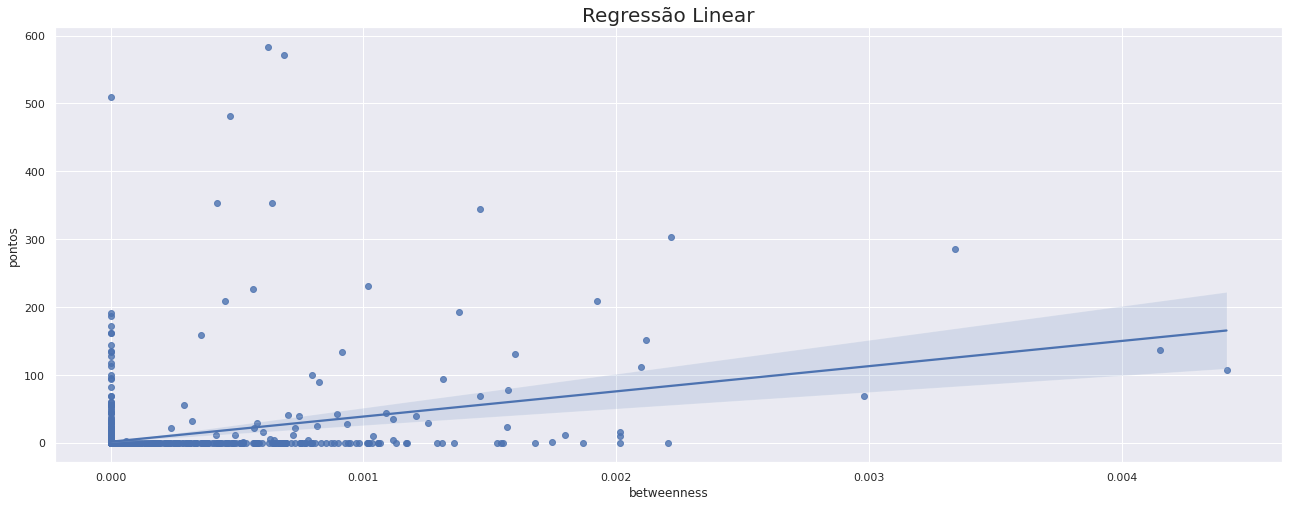

In [42]:
sns.set()

plt.figure(figsize=(22,8))
sns.regplot(x=df['betweenness'], y=df['pontos'])
plt.title("Regressão Linear", fontsize=20)
plt.show()

In [43]:
model = smf.ols(data=df, formula='pontos ~ betweenness')
result_with_zero = model.fit()
result_with_zero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     484.0
Date:                Tue, 23 Nov 2021   Prob (F-statistic):          4.35e-101
Time:                        00:01:20   Log-Likelihood:                -17517.
No. Observations:                3819   AIC:                         3.504e+04
Df Residuals:                    3817   BIC:                         3.505e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1512      0.392      2.937      0.003       0.383       1.920
betweenness  3.716e+04   1689.171     21.999      0.000    3.38e+04    4.05e+04
==============================================================================
Omnibus:                     7286.941   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12711067.445
Skew:                          14.655   Prob(JB):                         0.00
Kurtosis:                     284.108   Cond. No.                     4.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

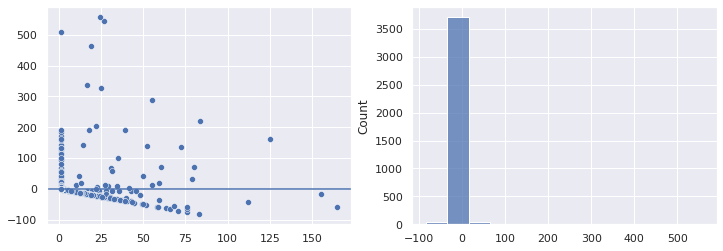

In [45]:
linear_resplot(result_with_zero)

In [46]:
df2 = df[(df['pontos'] > 0)]

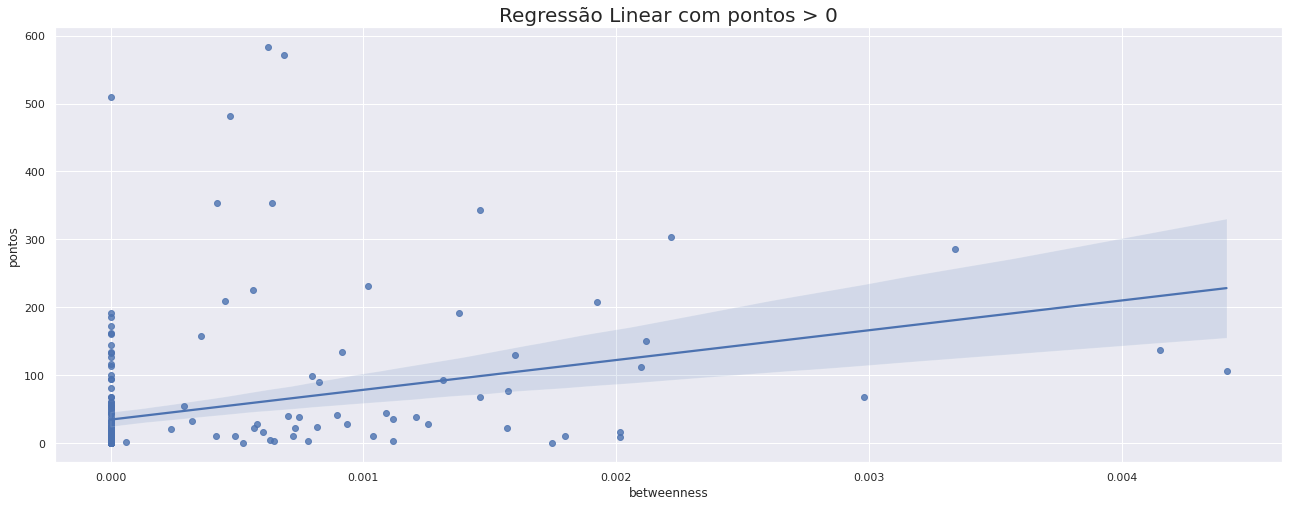

In [47]:
sns.set()
plt.figure(figsize=(22,8))
sns.regplot(x=df2['betweenness'], y=df2['pontos'])
plt.title("Regressão Linear com pontos > 0", fontsize=20)
plt.show()

In [48]:
model = smf.ols(data=df2, formula='pontos ~ betweenness') 
result_not_zero = model.fit()
result_not_zero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     25.87
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           7.74e-07
Time:                        00:01:21   Log-Likelihood:                -1326.5
No. Observations:                 225   AIC:                             2657.
Df Residuals:                     223   BIC:                             2664.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.7489      6.432      5.402      0.000      22.073      47.425
betweenness  4.385e+04   8621.109      5.086      0.000    2.69e+04    6.08e+04
==============================================================================
Omnibus:                      198.629   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2734.551
Skew:                           3.579   Prob(JB):                         0.00
Kurtosis:                      18.506   Cond. No.                     1.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

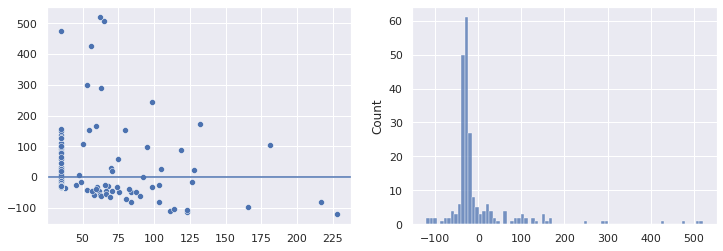

In [49]:
linear_resplot(result_not_zero)

In [50]:
df3 = df[(df['pontos'] >0) & (df['betweenness'] > 0.0000000001)]

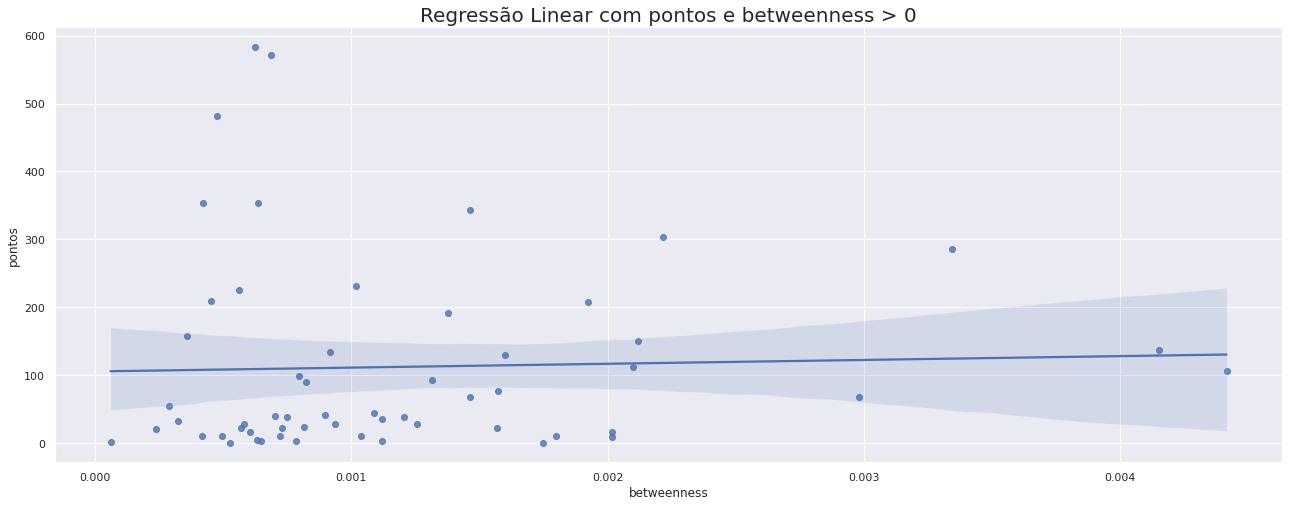

In [51]:
sns.set()
plt.figure(figsize=(22,8))
sns.regplot(x=df3['betweenness'], y=df3['pontos'])
plt.title("Regressão Linear com pontos e betweenness > 0", fontsize=20)
plt.show()

In [52]:
model = smf.ols(data=df3, formula='pontos ~ betweenness') 
result_not_zero_total = model.fit()
result_not_zero_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                   0.06997
Date:                Tue, 23 Nov 2021   Prob (F-statistic):              0.792
Time:                        00:01:22   Log-Likelihood:                -363.00
No. Observations:                  57   AIC:                             730.0
Df Residuals:                      55   BIC:                             734.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     105.6509     31.627      3.341      0.002      42.269     169.033
betweenness  5643.4121   2.13e+04      0.265      0.792   -3.71e+04    4.84e+04
==============================================================================
Omnibus:                       29.293   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.428
Skew:                           1.812   Prob(JB):                     1.85e-11
Kurtosis:                       5.772   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

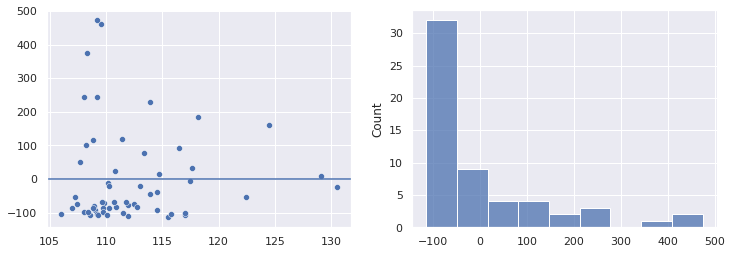

In [53]:
linear_resplot(result_not_zero_total)

In [57]:
df.sort_values(by=['betweenness'], inplace=True, ascending=False)
all_df = df[(df["pontos"] > 70) & (df["betweenness"] > 0.000000000000001)]
all_df[["name", "league", "betweenness", "pontos"]]

,name,league,betweenness,pontos
372,Spartak Moscow,Premier Liga,0.004415,107
148,SL Benfica,Liga Nos,0.004150,137
143,FC Porto,Liga Nos,0.003342,286
472,Chelsea FC,Premier League,0.002216,303
87,PSV Eindhoven,Eredivisie,0.002119,151
203,AS Monaco,Ligue 1,0.002100,112
507,Liverpool FC,Premier League,0.001924,208
257,AS Roma,Ligue 1,0.001601,130
150,Olympique Marseille,Liga Nos,0.001573,77
314,Juventus FC,Serie A,0.001463,344
